In [286]:
!pip install -qq catboost optuna

In [287]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00468/online_shoppers_intention.csv

--2022-06-01 12:47:54--  https://archive.ics.uci.edu/ml/machine-learning-databases/00468/online_shoppers_intention.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1072063 (1.0M) [application/x-httpd-php]
Saving to: ‘online_shoppers_intention.csv.2’

online_shoppers_int 100%[===================>]   1.02M  2.43MB/s    in 0.4s    

2022-06-01 12:47:55 (2.43 MB/s) - ‘online_shoppers_intention.csv.2’ saved [1072063/1072063]



In [385]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, roc_auc_score, precision_recall_curve
from sklearn.metrics import precision_score, recall_score, accuracy_score

from catboost import CatBoostClassifier, Pool, EFeaturesSelectionAlgorithm, EShapCalcType

import optuna
from optuna.samplers import TPESampler
from imblearn.over_sampling import SMOTENC

seed = 42
np.random.seed(seed)

In [289]:
df = pd.read_csv('online_shoppers_intention.csv')

In [290]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [291]:
df['Revenue'].value_counts()

False    10422
True      1908
Name: Revenue, dtype: int64

In [292]:
df.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


In [293]:
df.describe(exclude='number')

,Month,VisitorType,Weekend,Revenue
count,12330,12330,12330,12330
unique,10,3,2,2
top,May,Returning_Visitor,False,False
freq,3364,10551,9462,10422


In [294]:
def report(y_train, y_train_pred, y_test, y_test_pred, y_train_proba=None, y_test_proba=None):
    print('Train\n', classification_report(y_train, y_train_pred, digits=3))
    print('Test\n', classification_report(y_test, y_test_pred, digits=3))
    if y_train_proba is not None and y_test_proba is not None:
        roc_train, roc_test = roc_auc_score(y_train, y_train_proba), roc_auc_score(y_test, y_test_proba)
        print(f'Train ROC_AUC: {roc_train:.4f}, Test ROC_AUC: {roc_test:.4f}')
    print('Confusion Matrix', '\n', pd.crosstab(y_test, y_test_pred))
    
def reduce_memory(df):
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object and str(col_type)[:4] != 'uint' and str(col_type) != 'category':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif str(col_type)[:4] != 'uint':
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024 ** 2
    return df


In [295]:
df['Revenue'] = df['Revenue'].map({True:1, False:0}).astype(np.uint8)

In [296]:
df.skew().sort_values(ascending=False)

Informational_Duration     7.579185
ProductRelated_Duration    7.263228
PageValues                 6.382964
Administrative_Duration    5.615719
ProductRelated             4.341516
Informational              4.036464
SpecialDay                 3.302667
Browser                    3.242350
BounceRates                2.947855
ExitRates                  2.148789
OperatingSystems           2.066285
TrafficType                1.962987
Administrative             1.960357
Revenue                    1.909509
Weekend                    1.265962
Region                     0.983549
dtype: float64

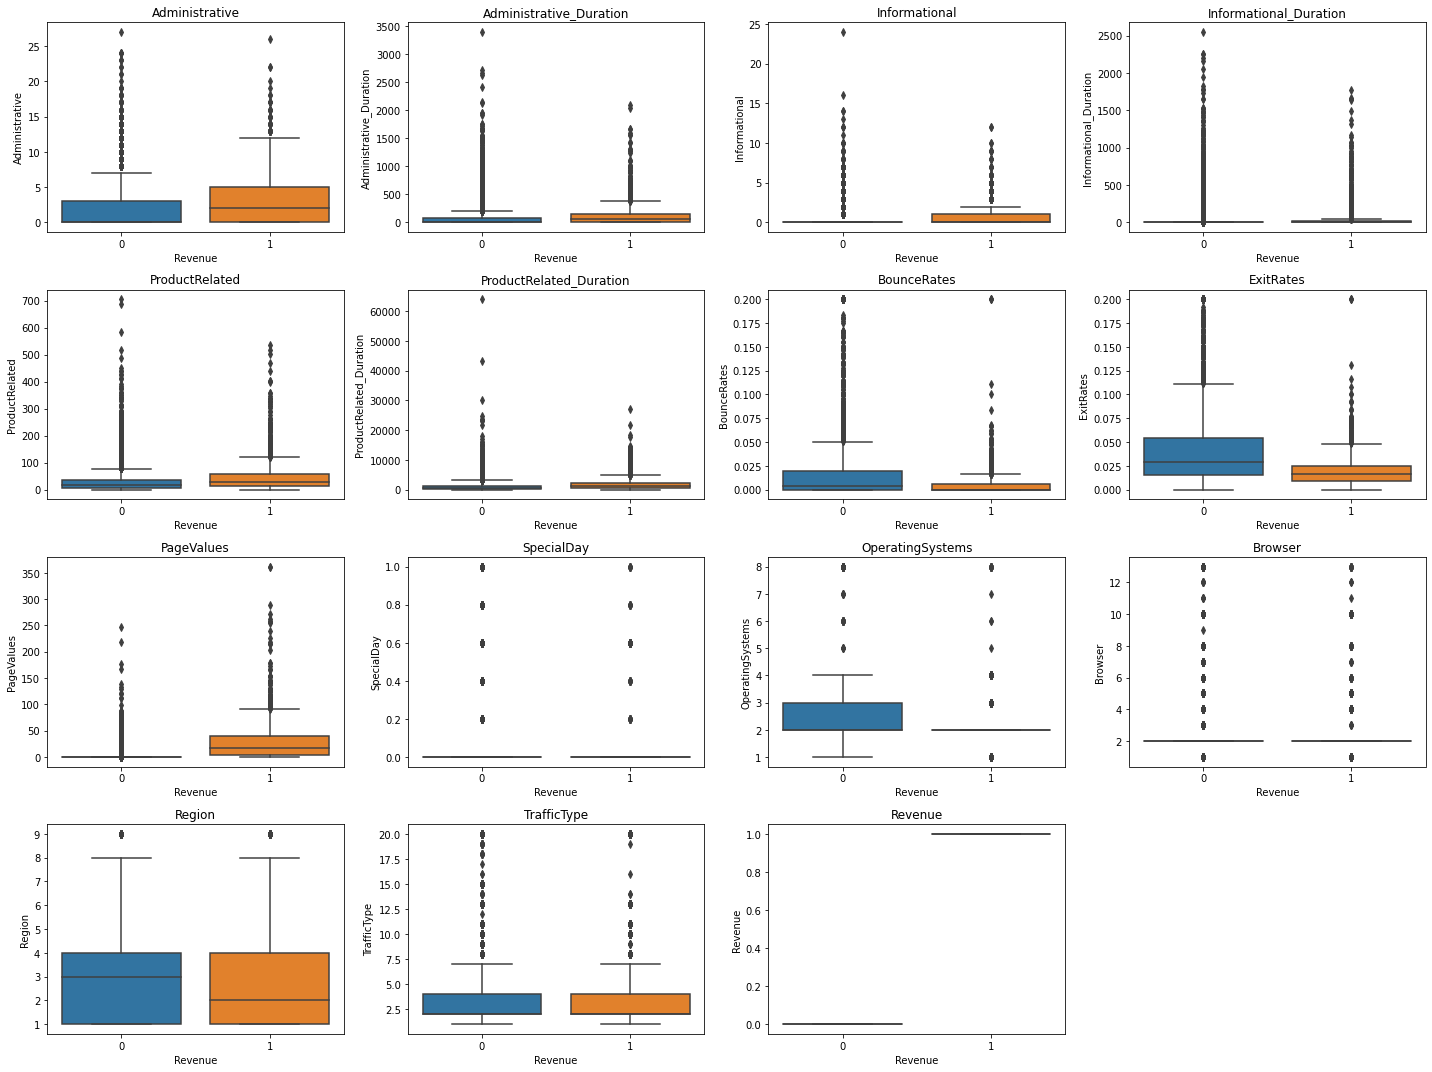

In [297]:
plt.figure(figsize=(20,15))
for i, column in enumerate(df.select_dtypes(include='number').columns, 1):
    plt.subplot(4, 4, i)
    plt.title(f'{column}')
    sns.boxplot(y=df[column], x=df['Revenue'], data=df)
plt.tight_layout()
plt.show()

In [298]:
df = reduce_memory(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Administrative           12330 non-null  int8    
 1   Administrative_Duration  12330 non-null  float32 
 2   Informational            12330 non-null  int8    
 3   Informational_Duration   12330 non-null  float32 
 4   ProductRelated           12330 non-null  int16   
 5   ProductRelated_Duration  12330 non-null  float32 
 6   BounceRates              12330 non-null  float32 
 7   ExitRates                12330 non-null  float32 
 8   PageValues               12330 non-null  float32 
 9   SpecialDay               12330 non-null  float32 
 10  Month                    12330 non-null  category
 11  OperatingSystems         12330 non-null  int8    
 12  Browser                  12330 non-null  int8    
 13  Region                   12330 non-null  int8    
 14  Traffi

### Train catboost ordinal model

In [299]:
X, y = df.drop('Revenue', axis=1), df['Revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=2500, shuffle=True, stratify=y, random_state=seed)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=1500, shuffle=True, stratify=y_train, random_state=seed)
print(f'Train size: {len(y_train)}, validation size: {len(y_valid)}, test size: {len(y_test)}')

Train size: 8330, validation size: 1500, test size: 2500


In [300]:
cat_cols = df.select_dtypes(include=['category', np.int8, np.int16]).columns.tolist()
train_pool = Pool(X_train, y_train, cat_features=cat_cols)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_cols)

In [301]:
base_cat = CatBoostClassifier(verbose=0).fit(train_pool, eval_set=valid_pool)

base_train_pred = base_cat.predict(X_train)
base_test_pred = base_cat.predict(X_test)

base_train_probs = base_cat.predict_proba(X_train)[:,1]
base_test_probs = base_cat.predict_proba(X_test)[:,1]

report(y_train, base_train_pred, y_test, base_test_pred, base_train_probs, base_test_probs)

Train
               precision    recall  f1-score   support

           0      0.944     0.972     0.958      7041
           1      0.820     0.685     0.746      1289

    accuracy                          0.928      8330
   macro avg      0.882     0.829     0.852      8330
weighted avg      0.925     0.928     0.925      8330

Test
               precision    recall  f1-score   support

           0      0.927     0.958     0.942      2113
           1      0.721     0.587     0.647       387

    accuracy                          0.901      2500
   macro avg      0.824     0.772     0.795      2500
weighted avg      0.895     0.901     0.897      2500

Train ROC_AUC: 0.9596, Test ROC_AUC: 0.9320
Confusion Matrix 
 col_0       0    1
Revenue           
0        2025   88
1         160  227


In [302]:
precision, recall, thresholds = precision_recall_curve(y_test, base_test_probs)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.368307, F-Score=0.677, Precision=0.667, Recall=0.687


In [303]:
def select_features(algorithm: EFeaturesSelectionAlgorithm, steps: int = 2, num_select=13):
        model = CatBoostClassifier(iterations=200, auto_class_weights='Balanced', random_seed=seed)
        summary = model.select_features(
            train_pool,
            eval_set=valid_pool,
            features_for_select=list(range(train_pool.num_col())),
            num_features_to_select=num_select,
            steps=steps,
            algorithm=algorithm,
            shap_calc_type=EShapCalcType.Regular,
            train_final_model=False,
            logging_level='Silent',
            plot=True
        )
        return summary

In [16]:
summary = select_features(EFeaturesSelectionAlgorithm.RecursiveByShapValues, num_select=15, steps=2)
X = X[summary['selected_features_names']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=2500, shuffle=True, stratify=y, random_state=seed)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=1500, shuffle=True, stratify=y_train, random_state=seed)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [11]:
cat_cols = X.select_dtypes(include=['category', np.int8, np.int16]).columns.tolist()
train_pool = Pool(X_train, y_train, cat_features=cat_cols)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_cols)

In [18]:
params_model = {
    'eval_metric': 'F1', 
    'iterations': 2000,
    'silent': True,
    'early_stopping_rounds': 10,
    'allow_writing_files': False,
    'grow_policy': 'SymmetricTree',
    'use_best_model': True,
    'random_seed': seed,
    'combinations_ctr': ['Counter:CtrBorderCount=120:Prior=0.5/1'],
    'simple_ctr': ['Counter:CtrBorderCount=120:Prior=0.5/1'],
    }

In [19]:
def objective(trial):
    param_trials = {
                    'depth': trial.suggest_int('depth', 3, 9),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
                    'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1., 5.),
                    'bagging_temperature': trial.suggest_float('bagging_temperature', 1., 3.),
                    'subsample': trial.suggest_float('subsample', 0.3, 1.),
                    'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.3, 1.),
                    'boosting_type': trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
                    'auto_class_weights': trial.suggest_categorical('auto_class_weights', ['Balanced', 'SqrtBalanced']),
                    'one_hot_max_size': trial.suggest_int('one_hot_max_size', 3, 16),
                    'max_ctr_complexity': trial.suggest_int('max_ctr_complexity', 3, 10),
                    }
    param_trials.update(params_model)
    
    opt_model = CatBoostClassifier(**param_trials)
    opt_model.fit(train_pool, eval_set=valid_pool)
    
    y_pred = opt_model.predict(X_valid)
    score = f1_score(y_valid, y_pred)
    
    return score

In [ ]:
optuna.logging.set_verbosity(optuna.logging.FATAL)
study = optuna.create_study(sampler=TPESampler(seed=seed), direction="maximize")
study.optimize(objective, n_trials=200, timeout=6000, n_jobs=-1)

print(f'Number of completed trials: {len(study.trials)}')
print('Best trial')
trial = study.best_trial
print(f'Best score: {trial.value}')
print('Best params')
for key, value in trial.params.items():
    print(f'{key}: {value}')

In [304]:
# if take all features
params_model = {
    'eval_metric': 'F1', 
    'iterations': 2000,
    'silent': True,
    'early_stopping_rounds': 5,
    'allow_writing_files': False,
    'grow_policy': 'SymmetricTree',
    'use_best_model': True,
    'random_seed': seed,
    'combinations_ctr': ['Counter:CtrBorderCount=120:Prior=0.5/1'],
    'simple_ctr': ['Counter:CtrBorderCount=120:Prior=0.5/1'],
    'auto_class_weights': 'SqrtBalanced',
    'bagging_temperature': 2.7663199021139073,
    'boosting_type': 'Plain',
    'colsample_bylevel': 0.7810192466472345,
    'depth': 6,
    'l2_leaf_reg': 2.6200141325970447,
    'learning_rate': 0.27246089668130946,
    'max_ctr_complexity': 6,
    'one_hot_max_size': 13,
    'subsample': 0.720762012326664
}

In [305]:
cat = CatBoostClassifier(**params_model).fit(train_pool, eval_set=valid_pool)

train_pred = cat.predict(X_train)
test_pred = cat.predict(X_test)

train_probs = cat.predict_proba(X_train)[:,1]
test_probs = cat.predict_proba(X_test)[:,1]

report(y_train, train_pred, y_test, test_pred, train_probs, test_probs)

Train
               precision    recall  f1-score   support

           0      0.955     0.922     0.938      7041
           1      0.642     0.760     0.696      1289

    accuracy                          0.897      8330
   macro avg      0.798     0.841     0.817      8330
weighted avg      0.906     0.897     0.901      8330

Test
               precision    recall  f1-score   support

           0      0.950     0.919     0.934      2113
           1      0.624     0.734     0.675       387

    accuracy                          0.890      2500
   macro avg      0.787     0.826     0.804      2500
weighted avg      0.899     0.890     0.894      2500

Train ROC_AUC: 0.9376, Test ROC_AUC: 0.9205
Confusion Matrix 
 col_0       0    1
Revenue           
0        1942  171
1         103  284


In [306]:
def get_best_threshold(y_true, y_score):
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    fscore = 2 * precision * recall / (precision + recall + 1e-10)
    ix = np.argmax(fscore)
    return thresholds[ix], fscore[ix]

In [307]:
thres, _ = get_best_threshold(y_test, test_probs)

In [308]:
labels = (test_probs >= thres).astype(np.uint8)

In [309]:
metrics = pd.DataFrame(columns=['F1', 'Precision', 'Recall', 'AUC', 'Accuracy', 'Threshold'])

In [310]:
metrics.loc['Base', :] = [f1_score(y_test, labels), precision_score(y_test, labels), recall_score(y_test, labels),
                          roc_auc_score(y_test, test_probs), accuracy_score(y_test, labels), thres]
metrics

,F1,Precision,Recall,AUC,Accuracy,Threshold
Base,0.678744,0.637188,0.726098,0.92045,0.8936,0.536921


### PU learning

In [364]:
p = 0.25
# add valid data to get more samples as we are not going to split train data into train and valid sets
# like in labeled dataset
mod_data = pd.concat([X_train, X_valid], axis=0)
mod_data['Revenue'] = pd.concat([y_train, y_valid], axis=0)
mod_data = mod_data.reset_index(drop=True)

pos_ind = np.where(mod_data.iloc[:,-1].values == 1)[0]

np.random.shuffle(pos_ind)

pos_sample_len = int(np.ceil(p * len(pos_ind)))
print(f'Using {pos_sample_len}/{len(pos_ind)} as positives and unlabeling the rest')
pos_sample = pos_ind[:pos_sample_len]

Using 381/1521 as positives and unlabeling the rest


In [365]:
mod_data['class_test'] = -1
mod_data.loc[pos_sample,'class_test'] = 1
print('target variable:\n', mod_data.iloc[:,-1].value_counts())

target variable:
 -1    9449
 1     381
Name: class_test, dtype: int64


In [366]:
mod_data = mod_data.sample(frac=1, random_state=seed)

data_N = mod_data[mod_data['class_test'] == -1]
data_P = mod_data[mod_data['class_test'] == 1]

neg_sample = data_N[:data_P.shape[0]]
sample_test = data_N[data_P.shape[0]:]
pos_sample = data_P.copy()

print(neg_sample.shape, pos_sample.shape)
sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1, random_state=seed)

(381, 19) (381, 19)


In [367]:
sample_train.loc[sample_train.class_test == -1, 'class_test'] = 0

X_sample, y_sample, y_target = sample_train.drop(['Revenue', 'class_test'],axis=1), sample_train['Revenue'], sample_train['class_test']

In [368]:
pcat = CatBoostClassifier(verbose=0, 
                          iterations=20,
                          subsample=0.3,
                          depth=5,
                          random_seed=seed,
                          grow_policy='SymmetricTree',
                          boosting_type='Ordered',
                          learning_rate=0.1, 
                          cat_features=cat_cols).fit(X_sample, y_target)

In [370]:
ptrain_pred = pcat.predict(X_sample)
ptest_pred = pcat.predict(X_test)

ptrain_probs = pcat.predict_proba(X_sample)[:,1]
ptest_probs = pcat.predict_proba(X_test)[:,1]

report(y_target, ptrain_pred, y_test, ptest_pred, ptrain_probs, ptest_probs)

Train
               precision    recall  f1-score   support

           0      0.784     0.829     0.806       381
           1      0.819     0.772     0.795       381

    accuracy                          0.801       762
   macro avg      0.802     0.801     0.800       762
weighted avg      0.802     0.801     0.800       762

Test
               precision    recall  f1-score   support

           0      0.953     0.903     0.927      2113
           1      0.589     0.755     0.661       387

    accuracy                          0.880      2500
   macro avg      0.771     0.829     0.794      2500
weighted avg      0.896     0.880     0.886      2500

Train ROC_AUC: 0.9004, Test ROC_AUC: 0.9089
Confusion Matrix 
 col_0       0    1
Revenue           
0        1909  204
1          95  292


In [387]:
p = 0.25
# train set only
mod_data = X_train.copy()
mod_data['Revenue'] = y_train
mod_data = mod_data.reset_index(drop=True)

pos_ind = np.where(mod_data.iloc[:,-1].values == 1)[0]

np.random.shuffle(pos_ind)

pos_sample_len = int(np.ceil(p * len(pos_ind)))
pos_sample = pos_ind[:pos_sample_len]

mod_data['class_test'] = -1
mod_data.loc[pos_sample,'class_test'] = 1

mod_data = mod_data.sample(frac=1, random_state=seed)

data_N = mod_data[mod_data['class_test'] == -1]
data_P = mod_data[mod_data['class_test'] == 1]

neg_sample = data_N[:data_P.shape[0]]
sample_test = data_N[data_P.shape[0]:]
pos_sample = data_P.copy()

sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1, random_state=seed)

sample_train.loc[sample_train.class_test == -1, 'class_test'] = 0

X_sample, y_target = sample_train.drop(['Revenue', 'class_test'],axis=1), sample_train['class_test']

pcat = CatBoostClassifier(verbose=0, 
                          iterations=20,
                          subsample=0.3,
                          depth=5,
                          random_seed=seed,
                          grow_policy='SymmetricTree',
                          boosting_type='Ordered',
                          learning_rate=0.1, 
                          cat_features=cat_cols).fit(X_sample, y_target)

ptrain_pred = pcat.predict(X_sample)
ptest_pred = pcat.predict(X_test)

ptrain_probs = pcat.predict_proba(X_sample)[:,1]
ptest_probs = pcat.predict_proba(X_test)[:,1]

report(y_target, ptrain_pred, y_test, ptest_pred, ptrain_probs, ptest_probs)

Train
               precision    recall  f1-score   support

           0      0.790     0.793     0.791       323
           1      0.792     0.789     0.791       323

    accuracy                          0.791       646
   macro avg      0.791     0.791     0.791       646
weighted avg      0.791     0.791     0.791       646

Test
               precision    recall  f1-score   support

           0      0.957     0.884     0.919      2113
           1      0.553     0.783     0.648       387

    accuracy                          0.868      2500
   macro avg      0.755     0.833     0.784      2500
weighted avg      0.894     0.868     0.877      2500

Train ROC_AUC: 0.8613, Test ROC_AUC: 0.9060
Confusion Matrix 
 col_0       0    1
Revenue           
0        1868  245
1          84  303


#### Compare

In [394]:
p_values = [0.1, 0.25, 0.3, 0.6, 0.5, 0.75, 0.9]

for p in p_values:
    mod_data = pd.concat([X_train, X_valid], axis=0)
    mod_data['Revenue'] = pd.concat([y_train, y_valid], axis=0)
    mod_data = mod_data.reset_index(drop=True)
    pos_ind = np.where(mod_data.iloc[:,-1].values == 1)[0]
    np.random.seed(seed)
    np.random.shuffle(pos_ind)
    pos_sample_len = int(np.ceil(p * len(pos_ind)))
    pos_sample = pos_ind[:pos_sample_len]

    mod_data['class_test'] = -1
    mod_data.loc[pos_sample,'class_test'] = 1

    mod_data = mod_data.sample(frac=1, random_state=seed)
    data_N = mod_data[mod_data['class_test'] == -1]
    data_P = mod_data[mod_data['class_test'] == 1]
    neg_sample = data_N[:data_P.shape[0]]
    sample_test = data_N[data_P.shape[0]:]
    pos_sample = data_P.copy()
    sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1, random_state=seed)
    sample_train.loc[sample_train.class_test == -1, 'class_test'] = 0
    X_sample, y_target = sample_train.drop(['Revenue', 'class_test'],axis=1), sample_train['class_test']

    pcat = CatBoostClassifier(verbose=0, 
                              iterations=20,
                              subsample=0.3,
                              depth=5,
                              random_seed=seed,
                              grow_policy='SymmetricTree',
                              boosting_type='Ordered',
                              learning_rate=0.1, 
                              cat_features=cat_cols).fit(X_sample, y_target)

    ptest_pred = pcat.predict(X_test)
    ptest_probs = pcat.predict_proba(X_test)[:,1]
    thres, _ = get_best_threshold(y_test, ptest_probs)
    labels = (ptest_probs >= thres).astype(np.uint8)

    metrics.loc[f'PU_{p}', :] = [f1_score(y_test, labels), precision_score(y_test, labels), recall_score(y_test, labels),
                                 roc_auc_score(y_test, ptest_probs), accuracy_score(y_test, labels), thres]

metrics.sort_values('F1')

,F1,Precision,Recall,AUC,Accuracy,Threshold
PU_0.1,0.646919,0.597374,0.705426,0.898678,0.8808,0.605944
PU_0.75,0.652226,0.61036,0.700258,0.918643,0.8844,0.660266
PU_0.25,0.652968,0.584867,0.739018,0.90785,0.8784,0.589149
PU_0.6,0.653625,0.589212,0.73385,0.906776,0.8796,0.607592
PU_0.3,0.654628,0.581162,0.749354,0.916219,0.8776,0.585807
PU_0.5,0.655212,0.588477,0.739018,0.913574,0.8796,0.593395
PU_0.9,0.655481,0.577909,0.757106,0.913831,0.8768,0.576364
Base,0.678744,0.637188,0.726098,0.92045,0.8936,0.536921
